In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from classes import BaseModel, load_model, generate_text, TextTokenizer
import math


# BASEMODEL_CONFIG = {
#     "vocab_size": 50257,
#     "max_length": 300,
#     "context_length": 300,
#     "embedding_dim": 768,
#     "n_layers": 12,
#     "n_heads": 16,
#     "dropout": 0.15,
#     "qkv_bias": False,
#     "batch_size": 2,
#     "learning_rate": 0.0004,
#     "weight_decay": 0.1
# }

BASEMODEL_CONFIG = {
    "vocab_size": 50257,
    "max_length": 300,
    "context_length": 300,
    "embedding_dim": 384,
    "n_layers": 8,
    "n_heads": 8,
    "dropout": 0.10,
    "qkv_bias": False,
    "batch_size": 8,
    "learning_rate": 0.0004,
    "weight_decay": 0.1
}


SEED = 19
NUM_SENTIMENT_CLASSES = 2
print(f"Is CUDA available: {torch.cuda.is_available()}")

Is CUDA available: True


## Loading and splitting data

In [2]:
def split_train_val(df, train_frac):
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_index = int(len(df) * train_frac)

    train_df = df[:split_index]
    val_df = df[split_index:]

    return train_df, val_df

In [3]:
raw_train = pd.read_csv("dataset/train/train_data.csv")
train_df, val_df = split_train_val(raw_train, train_frac=0.9)
test_df = pd.read_csv("dataset/test/test_data.csv")

train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

# train_df.to_csv("dataset/new_sentiment_data/train.csv", index=None, encoding="utf-8")
# val_df.to_csv("dataset/new_sentiment_data/validation.csv", index=None, encoding="utf-8")
# test_df.to_csv("dataset/new_sentiment_data/test.csv", index=None, encoding="utf-8")

In [4]:
display(train_df.head(15))

,text,sentiment
0,yay finally able change picture,1
1,really miss perfect little orange wallet still...,0
2,cant sleep good,0
3,studying filipino test tooooom,0
4,every time fall asleep dreams haunted every ti...,1
5,get license week haha im exciteddd,1
6,lappy charger completely dead conserving whats...,0
8,mcvalue lunched week fave spicy chicken mcdelu...,1
9,yay english assignment heaps fun,0
10,back edinburgh tomorrow england awesome though,1


In [5]:
def get_sentiment_counts(df, set_name):
    counts = df["sentiment"].value_counts().reset_index()
    counts.columns = ['Sentiment', 'Count']
    counts['Set'] = set_name
    return counts

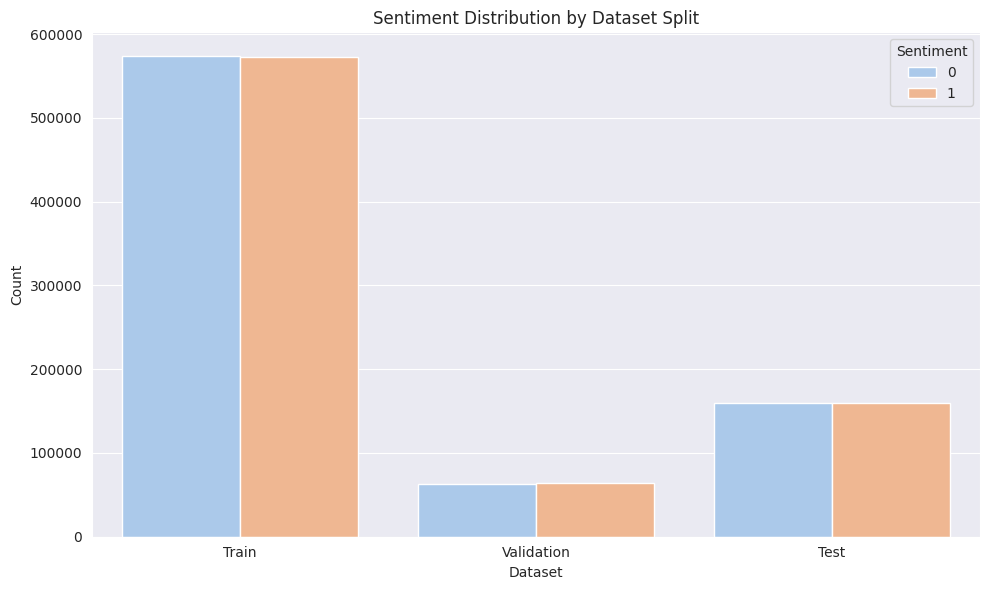

In [6]:
train_counts = get_sentiment_counts(train_df, "Train")
val_counts = get_sentiment_counts(val_df, "Validation")
test_counts = get_sentiment_counts(test_df, "Test")

sentiment_df = pd.concat([train_counts, val_counts, test_counts], ignore_index=True)
sns.axes_style()

plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_df, x='Set', y='Count', hue='Sentiment', palette="pastel")

plt.title('Sentiment Distribution by Dataset Split')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, csv_file, tt: TextTokenizer, max_length=None, pad_token_id=50256):
        self.df = pd.read_csv(csv_file, encoding="utf-8")

        self.encoded_texts = [tt.encode(txt) for txt in self.df["text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_txt[:self.max_length] for encoded_txt in self.encoded_texts]

        self.encoded_texts = [
            encoded_txt + [pad_token_id] * (self.max_length - len(encoded_txt))
            for encoded_txt in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        sentiment = self.df.iloc[index]["sentiment"]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(sentiment, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length

        return max_length

def create_dataloader(file, tt: TextTokenizer, batch_size=16, shuffle=True, drop_last=True, num_workers=0):
    csv_file = f"dataset/new_sentiment_data/{file}"
    model_dataset = SentimentDataset(csv_file, tt)
    dataloader = DataLoader(model_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [8]:
tt = TextTokenizer(tokenizer=tiktoken.get_encoding("gpt2"))
batch_size = 256 #8
num_workers = 0

torch.manual_seed(SEED)
train_loader = create_dataloader("train.csv", tt, batch_size, True, True, num_workers)
val_loader = create_dataloader("validation.csv", tt, batch_size, False, True, num_workers)
test_loader = create_dataloader("test.csv", tt, batch_size, False, False, num_workers)

In [9]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

4478 training batches
497 validation batches
1245 test batches


## Loading base model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, _ = load_model("models/SmallerModel_1kBase_MODEL-OPTIMIZER.pth", BASEMODEL_CONFIG, device, True)
model.eval()

new_text = generate_text(model, tt.to_token_ids("Small"), 20, BASEMODEL_CONFIG["context_length"], top_k=25, temperature=1.2)
print(f"Model output:\n{tt.to_text(new_text)}")

Model output:
Small of that
of these two things, and the other as they have seen of their dead lives


## Loaded model architecture

In [11]:
print(model)

BaseModel(
  (token_embeddings): Embedding(50257, 384)
  (pos_embeddings): Embedding(300, 384)
  (dropout_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=384, out_features=384, bias=False)
        (W_key): Linear(in_features=384, out_features=384, bias=False)
        (W_value): Linear(in_features=384, out_features=384, bias=False)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
      (norm1): NormLayer()
      (norm2): NormLayer()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAt

## Fine-tuning model to sentiment classification

In [12]:
def prepare_model_layers(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.transformer_blocks[-1].parameters():
        param.requires_grad = True

    for param in model.final_norm.parameters():
        param.requires_grad = True

In [13]:
prepare_model_layers(model)

torch.manual_seed(SEED)

model.out_head = torch.nn.Linear(
    in_features=BASEMODEL_CONFIG["embedding_dim"],
    out_features=NUM_SENTIMENT_CLASSES
)

In [15]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]

            probs = torch.softmax(logits, dim=-1)
            predicted_labels = torch.argmax(probs, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())

        else:
            break

    return correct_predictions / num_examples

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)

    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss / num_batches


def train_sentiment(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step, epoch_step = 0, -1, -1

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            epoch_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"Ep {epoch+1}/{num_epochs} "
                    f"(Step {int(math.ceil(epoch_step/eval_freq))}/{int(math.ceil(len(train_loader)/eval_freq))} [{(epoch_step/len(train_loader) * 100):.2f}%]): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

                train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
                val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

                print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
                print(f"Validation accuracy: {val_accuracy*100:.2f}%")
                train_accs.append(train_accuracy)
                val_accs.append(val_accuracy)

        epoch_step = -1

    return train_losses, val_losses, train_accs, val_accs, examples_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)

    model.train()
    return train_loss, val_loss

In [16]:
# torch.manual_seed(SEED)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 1
model.to(device)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_sentiment(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5
)

Ep 1/1 (Step 0/180 [0.00%]): Train loss 0.708, Val loss 0.698
Training accuracy: 49.22% | Validation accuracy: 52.89%
Ep 1/1 (Step 1/180 [0.56%]): Train loss 0.690, Val loss 0.682
Training accuracy: 51.80% | Validation accuracy: 55.39%
Ep 1/1 (Step 2/180 [1.12%]): Train loss 0.663, Val loss 0.653
Training accuracy: 58.75% | Validation accuracy: 59.77%
Ep 1/1 (Step 3/180 [1.67%]): Train loss 0.641, Val loss 0.629
Training accuracy: 62.42% | Validation accuracy: 63.59%
Ep 1/1 (Step 4/180 [2.23%]): Train loss 0.633, Val loss 0.622
Training accuracy: 63.83% | Validation accuracy: 64.92%
Ep 1/1 (Step 5/180 [2.79%]): Train loss 0.614, Val loss 0.639
Training accuracy: 65.47% | Validation accuracy: 64.69%
Ep 1/1 (Step 6/180 [3.35%]): Train loss 0.593, Val loss 0.596
Training accuracy: 64.69% | Validation accuracy: 67.50%
Ep 1/1 (Step 7/180 [3.91%]): Train loss 0.610, Val loss 0.612
Training accuracy: 65.55% | Validation accuracy: 66.17%
Ep 1/1 (Step 8/180 [4.47%]): Train loss 0.579, Val loss 

In [17]:
def plot_values(epoch_seen, train_values, val_values, label="loss"):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(epoch_seen, train_values, label=f"Training {label}")
    ax.plot(epoch_seen, val_values, label=f"Validation {label}", linestyle="-.")
    ax.set_title(label.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label.capitalize())

    ax.legend()
    fig.tight_layout()
    plt.show()

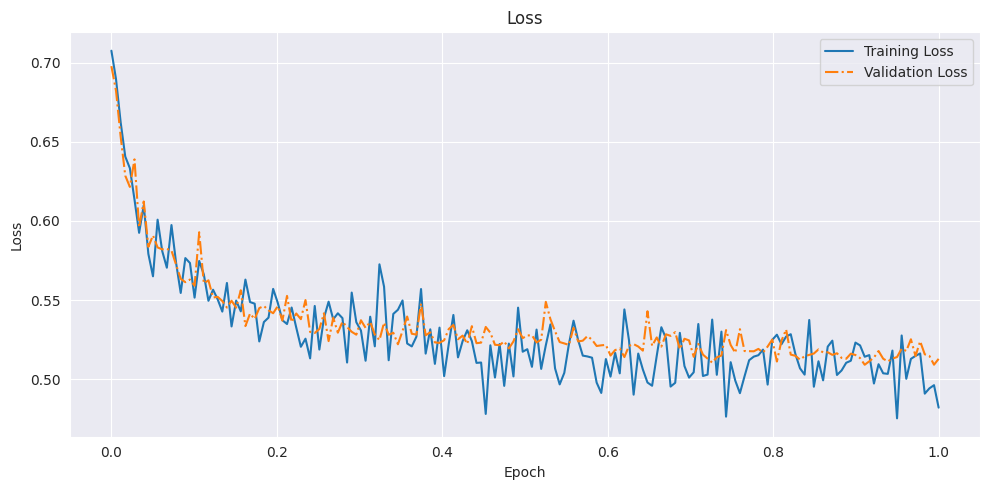

In [22]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)).to("cpu")
plot_values(epochs_tensor, [item.to("cpu") for item in train_losses], [item.to("cpu") for item in val_losses], "Loss")

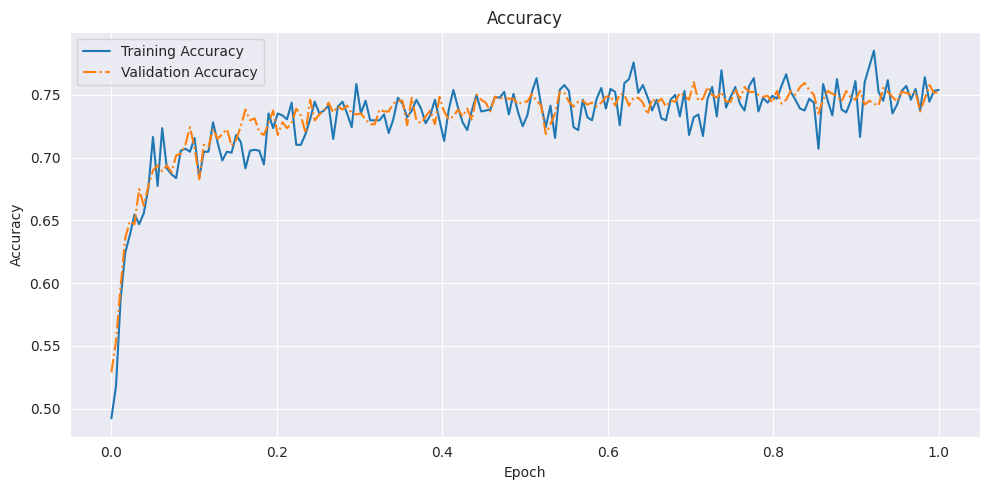

In [21]:
plot_values(epochs_tensor, train_accs, val_accs, "Accuracy")

## Save & Load model

In [24]:
def save_model(model, optimizer=None, filename="model"):
    # filename with no extension
    if optimizer is None:
        torch.save(model.state_dict(), f"models/{filename}_MODEL.pth")
    else:
        torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"models/{filename}_MODEL-OPTIMIZER.pth"
        )


def load_model(filepath, config, device, with_optimizer=False):
    checkpoint = torch.load(filepath, map_location=device)
    model = BaseModel(config)

    if not with_optimizer:
        model.load_state_dict(checkpoint)
        model.train()
        return model

    model.load_state_dict(checkpoint["model_state_dict"])
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer

In [25]:
save_model(model, None, filename="SentimentClassifier_1kBase")
save_model(model, optimizer, filename="SentimentClassifier_1kBase")

## Evaluating model

In [26]:
model.eval()
test_acc = calc_accuracy_loader(test_loader, model, device)

print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 74.29%
